In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-dataset/Titanic-Dataset.csv


# Welcome to this notebook on titanic survival prediction

In [2]:
# for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sb

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# ignoring warinngs
import warnings
warnings.filterwarnings('ignore')

# Reading the csv file and making dataframe

In [3]:
df = pd.read_csv('/kaggle/input/titanic-dataset/Titanic-Dataset.csv')

## Previewing the dataframe

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Checking dataframe infos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.shape

(891, 12)

In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Setting Up Enviroment

In [8]:
df['Sex_numeric'] = [1 if x=='male' else 0 for x in df['Sex']]

In [9]:
columns_to_drop = ["Name","Sex","Ticket","Cabin","Embarked"]
df.drop(columns_to_drop,axis="columns",inplace=True)

In [10]:
df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_numeric
0,1,0,3,22.0,1,0,7.2500,1
1,2,1,1,38.0,1,0,71.2833,0
2,3,1,3,26.0,0,0,7.9250,0
3,4,1,1,35.0,1,0,53.1000,0
4,5,0,3,35.0,0,0,8.0500,1
...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,1
887,888,1,1,19.0,0,0,30.0000,0
888,889,0,3,NaN,1,2,23.4500,0
889,890,1,1,26.0,0,0,30.0000,1


## Evaulating Correlations

In [11]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_numeric
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333
Sex_numeric,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000


## Our interest is to check corelation of Survived Column with rest

In [12]:
corr_df=pd.DataFrame(df.corr()['Survived'].drop('Survived'))

## Following Heatmap shows the strength of correlation of survival with the rest of the data

#### Note that in a heatmap the strong +ve correlations can be found at upper side while strong -ve correlation can be found at lower side while less correlated data lies at the middle

<Axes: >

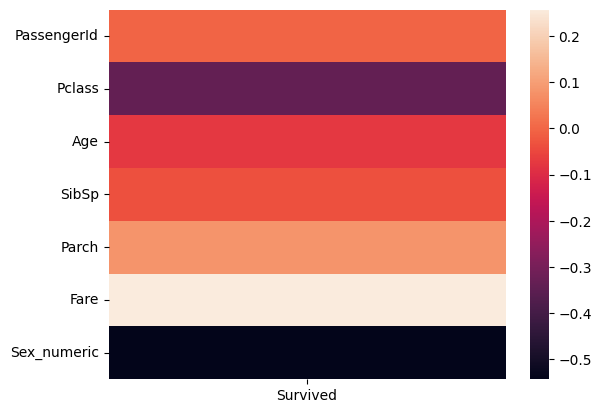

In [15]:
sb.heatmap(corr_df)

## Checking for the maximum corelated data and minimum corelated data with the result

In [17]:
max_positively_correlated = corr_df['Survived'].idxmax()
min_correlated = corr_df['Survived'].abs().idxmin()
max_negatively_correlated = corr_df['Survived'].idxmin()
print(f'max_positive_correlated: {max_positively_correlated}')
print(f'mix_correlated: {min_correlated}')
print(f'max_neg_correlated: {max_negatively_correlated}')

max_positive_correlated: Fare
mix_correlated: PassengerId
max_neg_correlated: Sex_numeric


## Dropping if the correlation is less than 20

In [18]:
dropping_values=corr_df[corr_df['Survived'].abs()<=0.2].index

In [19]:
dropping_values

Index(['PassengerId', 'Age', 'SibSp', 'Parch'], dtype='object')

In [20]:
feature_df=corr_df.drop(dropping_values,axis="rows")

In [21]:
feature_df

,Survived
Pclass,-0.338481
Fare,0.257307
Sex_numeric,-0.543351


# Now vizulising for anamolies

array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'Sex_numeric'}>, <Axes: >]], dtype=object)

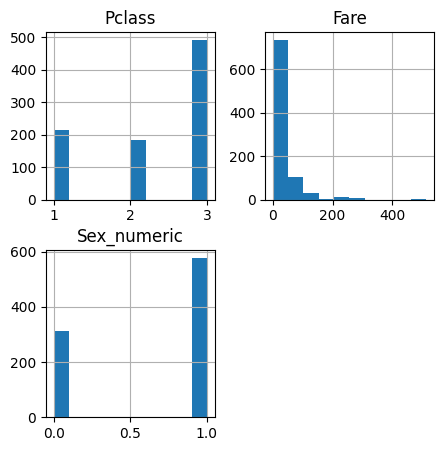

In [22]:
df[feature_df.index].hist(bins=10,figsize=(5,5))

In [23]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Age            177
SibSp            0
Parch            0
Fare             0
Sex_numeric      0
dtype: int64

#### Age is not in the feature so we ignore NA values here

# Machine Learning
## Defining feature and target

In [24]:
# x is feature dataset and y is the label
X = df[feature_df.index]
y = df['Survived']

In [25]:
# We also need to scale our data for better accuracy
scaler = MinMaxScaler()

In [26]:
X = scaler.fit_transform(X)

In [27]:
# Splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=3)

In [28]:
model = LogisticRegression()

In [29]:
model.fit(X_train, y_train)

LogisticRegression()

In [30]:
reg_pre_y = model.predict(X_test)

In [31]:
test_accuracy = roc_auc_score(y_test, reg_pre_y)

In [32]:
print(test_accuracy)

0.7593053735255569


In [33]:
print(classification_report(y_test, reg_pre_y))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       109
           1       0.67      0.76      0.71        70

    accuracy                           0.76       179
   macro avg       0.75      0.76      0.75       179
weighted avg       0.77      0.76      0.76       179



## Confusion Matrix

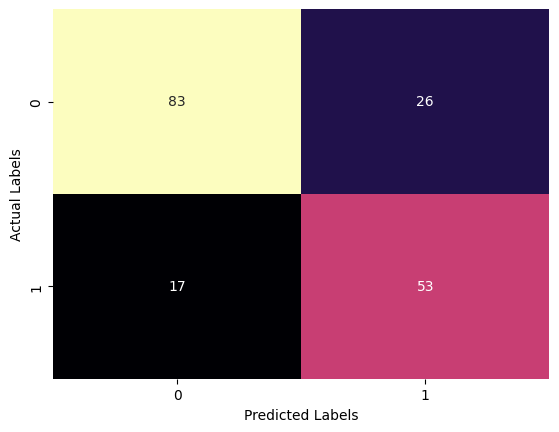

In [34]:
cm = confusion_matrix(y_test,reg_pre_y)
sb.heatmap(cm,cmap='magma',annot=True,cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

# Using Random Forest

In [35]:
rf_classifier = RandomForestClassifier(n_estimators=100,random_state=4)

In [36]:
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(random_state=4)

In [37]:
rf_pre_y = rf_classifier.predict(X_test)

In [38]:
print(classification_report(y_test,rf_pre_y))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       109
           1       0.76      0.74      0.75        70

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



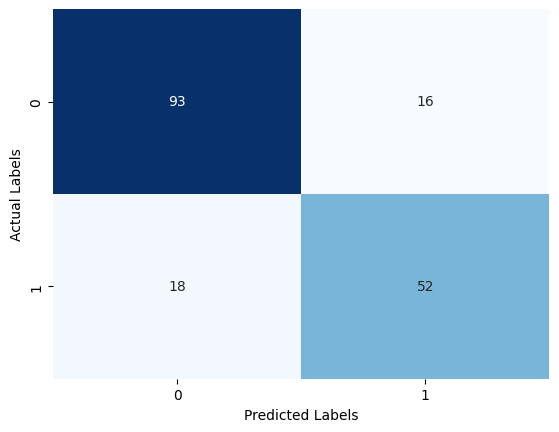

In [39]:
cm = confusion_matrix(y_test,rf_pre_y)
sb.heatmap(cm,cmap='Blues',annot=True,cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

# Decision Tree Classifier

In [40]:
Dec_tree = DecisionTreeClassifier()

In [41]:
Dec_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [42]:
Dec_tree_y = Dec_tree.predict(X_test)

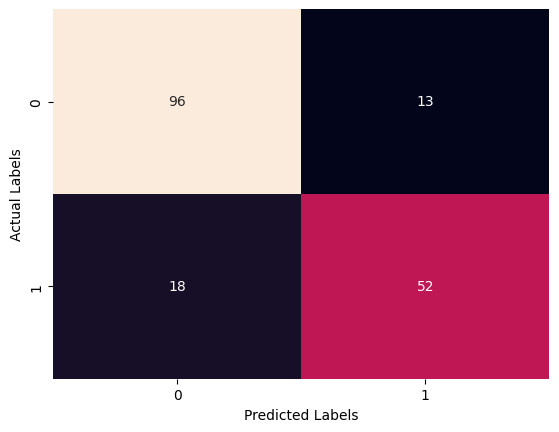

In [43]:
cm = confusion_matrix(y_test,Dec_tree_y)
sb.heatmap(cm,annot=True,cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

#### Explanation:
#### 96 passengers who are died are correctly predicted
#### 18 passengers who actually died but predicted as survived
#### 52 passengers who survived are correctly predicted
#### 13 passengers who actually survived but predicted as dead.

In [44]:
print(classification_report(y_test, Dec_tree_y))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       109
           1       0.80      0.74      0.77        70

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



# Conclusion:
#### As Decision Tree classifier gave about 83% accuracy. So it will be Used in the Titanic dataset to build a model that predicts whether a passenger on the Titanic survived or not.